In [4]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install latex
from utility import *

In [51]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import time 
import random
from qulacs import QuantumState, QuantumCircuit, Observable
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacsvis import circuit_drawer
from qulacs.gate import RandomUnitary
from qulacs.state import inner_product
from qulacs.gate import to_matrix_gate
import scipy.optimize

from qulacs.gate import Identity, X,Y,Z
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag
from qulacs.gate import T,Tdag
from qulacs.gate import RX,RY,RZ
from qulacs.gate import CNOT, CZ, SWAP

# 受講証明用課題②

ハミルトニアンを定義する。

$$H=\underbrace{X_0+X_1+X_2+X_3}_{H_X}+\underbrace{Z_0X_1Z_2+Z_1X_2Z_3}_{H_{ZXZ}}$$

In [52]:
# Define Hamiltonian
nqubits = 4
H_X = Observable(nqubits)
for i in range(nqubits):
    H_X.add_operator(1.0, f"X {i}")
H_ZXZ = Observable(nqubits)
H_ZXZ.add_operator(1.0, f"Z {0} X {1} Z {2}")
H_ZXZ.add_operator(1.0, f"Z {1} X {2} Z {3}")

## 状態の準備

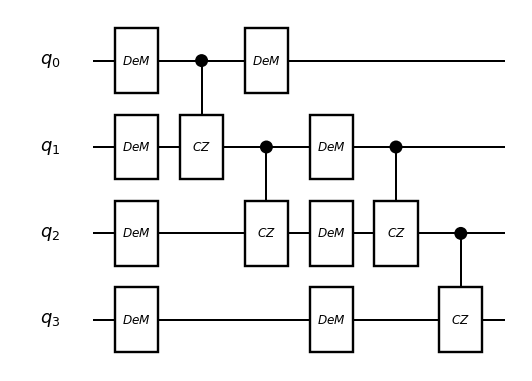

 *** Quantum State ***
 * Qubit Count : 4
 * Dimension   : 16
 * State vector : 
(0.133515,-0.00415851)
  (0.158743,0.0566187)
  (0.12063,-0.0553749)
  (0.307139,0.0274316)
 (0.0129182,-0.159307)
   (0.203477,-0.24864)
    (0.18223,0.133641)
    (0.161687,0.35593)
  (0.0886307,0.102939)
   (0.0566877,0.16174)
  (0.120902,0.0600106)
    (0.174625,0.26045)
 (-0.134253,0.0916109)
(-0.32671,-0.00200065)
(-0.0107836,-0.229548)
  (0.178156,-0.355386)



In [53]:
# Prepare quantum state
state = QuantumState(nqubits)
circuit = QuantumCircuit(nqubits)
depth = 2
np.random.seed(2)
for d in range(depth):
    for i in range(nqubits):
        circuit.add_U3_gate(i, *(2*np.pi*np.random.rand(3)))
    for i in range(nqubits//2):
        circuit.add_CZ_gate((i+d%2)%nqubits, (i+1+d%2)%nqubits)
circuit.update_quantum_state(state)
circuit_drawer(circuit, "mpl")
print(state)

## 物理量Xに対する測定

In [54]:
"""
    Sample observable X.
"""
def sample_X(nshots,state,nqubits):
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        
    samples = state.sampling(nshots)
    estimated_X_energy = 0
    mask_list = [0b0001,0b0010,0b0100,0b1000]
    for s in samples:
        for mask in mask_list:
            bitcount = bin(s & mask).count("1")
            estimated_X_energy += (-1)**bitcount/nshots
            
    for i in range(nqubits):
        H(i).update_quantum_state(state)
    
    return estimated_X_energy

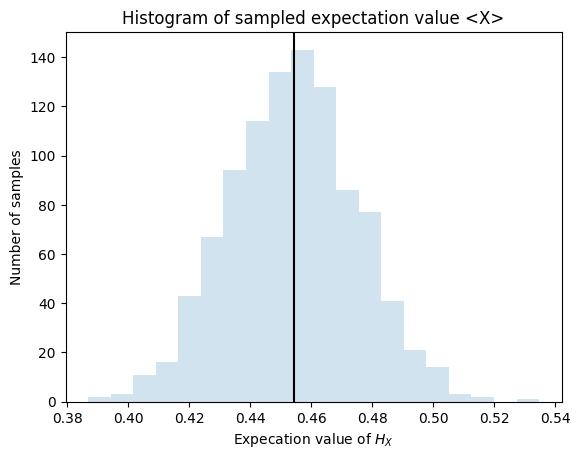

Expectation value of H_X:  0.4540101999999663
Exact value of H_X:  0.4544030785538582


In [55]:
ntest = 1000
nshots = 10000
result_list_X = np.zeros(ntest)
for i in range(ntest):
    result_list_X[i] = sample_X(nshots,state,nqubits)

plt.hist(result_list_X, alpha=0.2, bins=20)
H_X = Observable(nqubits)
for i in range(nqubits):
    H_X.add_operator(1.0, f"X {i}")
plt.axvline(H_X.get_expectation_value(state), color="black")
plt.title("Histogram of sampled expectation value <X>")
plt.xlabel("Expecation value of $H_X$")
plt.ylabel("Number of samples")
plt.show()

print("Expectation value of H_X: ", np.mean(result_list_X))
print("Exact value of H_X: ", H_X.get_expectation_value(state))

## 物理量ZXZに対する測定

In [56]:
"""
    Sample observable ZXZ.
"""
def sample_ZXZ(nshots,state,nqubits,index_X):
    H(index_X).update_quantum_state(state)
    samples = state.sampling(nshots)
    estimated_X_energy = 0
    if index_X == 1:
        mask_list = [0b0111]
    elif index_X == 2:
        mask_list = [0b1110]
    else:
        print("error: parameter \"index_X\" is invalid.")
        
    for s in samples:
        for mask in mask_list:
            bitcount = bin(s & mask).count("1")
            estimated_X_energy += (-1)**bitcount/nshots
    
    H(index_X).update_quantum_state(state)     
    return estimated_X_energy

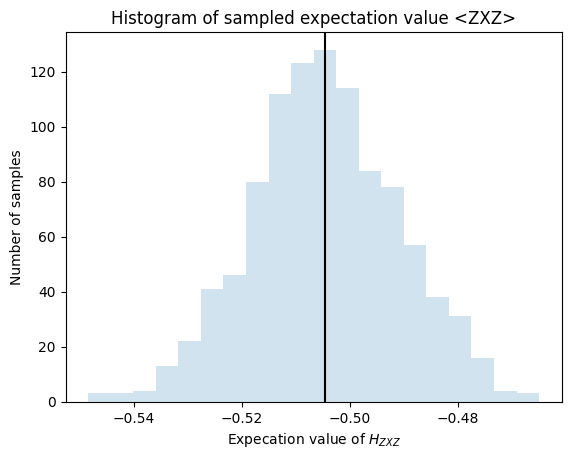

Expectation value of H_ZXZ:  -0.5045881999999771
Exact value of H_ZXZ:  -0.5045858961399986


In [57]:
ntest = 1000
nshots = 10000
result_list_ZXZ = np.zeros(ntest)
for i in range(ntest):
    result_list_ZXZ[i] = sample_ZXZ(nshots,state,nqubits,1) + sample_ZXZ(nshots,state,nqubits,2)

plt.hist(result_list_ZXZ, alpha=0.2, bins=20)
H_ZXZ = Observable(nqubits)
H_ZXZ.add_operator(1.0, "Z 0 X 1 Z 2")
H_ZXZ.add_operator(1.0, "Z 1 X 2 Z 3")
plt.axvline(H_ZXZ.get_expectation_value(state), color="black")
plt.title("Histogram of sampled expectation value <ZXZ>")
plt.xlabel("Expecation value of $H_{ZXZ}$")
plt.ylabel("Number of samples")
plt.show()

print("Expectation value of H_ZXZ: ", np.mean(result_list_ZXZ))
print("Exact value of H_ZXZ: ", H_ZXZ.get_expectation_value(state))

## 全ハミルトニアン$H$の期待値

In [58]:
sampled_expectation_value = np.mean(result_list_X) + np.mean(result_list_ZXZ)
print("Sampled expectation value of <H>", sampled_expectation_value)

H = Observable(nqubits)
for i in range(nqubits):
    H.add_operator(1.0, f"X {i}")
H.add_operator(1.0, f"Z {0} X {1} Z {2}")
H.add_operator(1.0, f"Z {1} X {2} Z {3}")
exact_expectation_value = H.get_expectation_value(state)
print("Exact expectation value of <H>: ", exact_expectation_value)


Sampled expectation value of <H> -0.05057800000001078
Exact expectation value of <H>:  -0.05018281758606735
